# Climate Change Belief Analysis Competition

# Importing the libraries

In [167]:
!pip install spacy
!pip install wordcloud
!pip install nltk

In [168]:
#standard libraries
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

#modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from sklearn.utils import resample

#text preprocessing libraries
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
import string

#pickling
import pickle

# Loading the datasets

In [169]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print (os.path.join(dirname,filename))

In [170]:
train_data = pd.read_csv('https://raw.githubusercontent.com/Paulinah26/Paulinah/main/train.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/Paulinah26/Paulinah/main/test.csv')

# Inspecting the data

In [171]:
train_data.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [172]:
test_data.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [173]:
len(train_data), len(test_data)

(15819, 10546)

The training set has 15819 tweets.

The testing set has 10546 tweets.

For ease, the tweetid column is set to be the index.

In [174]:
train_data.set_index('tweetid', inplace=True)
test_data.set_index('tweetid', inplace=True)

Checking for missing data:

In [175]:
train_data.isnull().sum()

sentiment    0
message      0
dtype: int64

In [176]:
test_data.isnull().sum()

message    0
dtype: int64

Checking for empty strings:

In [177]:
blanks = []  # start with an empty list

for i,lb,tw in train_data.itertuples():  # iterate over the DataFrame
    if type(tw)==str:                    # avoid NaN values
        if tw.isspace():                 # test 'review' for whitespace
            blanks.append(i)             # add matching index numbers to the list
        
print(len(blanks), 'blanks in train data: ', blanks)   # Checking for empty strings

0 blanks in train data:  []


In [178]:
blanks = []  # start with an empty list

for i, tw in test_data.iterrows():  # iterate over the DataFrame
    if type(tw)==str:            # avoid NaN values
        if tw.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks in test data: ', blanks)

0 blanks in test data:  []


The data has no missing values, and no empty tweet strings.

# Text preprocessing

# Noise Removal

Any piece of information (text) that is not relevant in the data is considered as noise. The following constitutes as noise: stop words, urls, links, social media entities, punctuations or any industry-specific words. Noise is to be removed from our data as it is not required.

Part of noise removal in this instance involves Object Standardization.

Object Standardization involves making sense of, or removing words or phrases which are not present in any standard lexical dictionaries. These pieces are not recognized by search engines and models. Some examples include acronyms, hashtags with attached words, and colloquial slangs.

In [179]:
#Converting every tweet to be lower case
train_data['message'] = train_data['message'].str.lower()
test_data['message'] = test_data['message'].str.lower()

In [180]:
def cleaning(text):
    
    """
    Function takes in a text, and returns it cleaned of all noise 
    (such as  unexpected artifacts, urls, twitter handles and numbers).
    
    """
    
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[\w]*','',text)
    text = re.sub(r'â€¦', '', text)
    text = re.sub(r'…', '', text)
    text = re.sub(r'â€™', "'", text)
    text = re.sub(r'â€˜', "'", text)
    text = re.sub(r'\$q\$', "'", text)
    text = re.sub(r'&amp;', "and", text)
    text = re.sub('[0-9]+', '', text)
    
    words = text.split()  
    
    return( " ".join(words))

In [181]:
train_data['message'] = train_data['message'].apply(cleaning)
test_data['message'] = test_data['message'].apply(cleaning)

Python's string library is used to remove punctuation.

In [182]:
def remove_punctuation(text):
    
    """custom function to remove the punctuation"""
    
    return text.translate(str.maketrans('', '', string.punctuation))

In [183]:
train_data['message'] = train_data['message'].apply(remove_punctuation)
test_data['message'] = test_data['message'].apply(remove_punctuation)

The tweets contain 'rt',impying a retweet

'rt','rts' and 'retweet' are added as stopwords, and all stopwords are now removed.

In [184]:
#Remove Stop words
def stop(text):
    
    """" 
    Function takes in some text, adds the variants of 'retweets'
    into the stopwords list, and then removes all stopwords.
    
    """
    
    word = text.split()
    #Remove stop words
    stop_additional = ['rt','rts', 'retweet']
    stop_word = set().union(stopwords.words('english'), stop_additional)
    remove_stop = [w for w in word if w not in stop_word]
    free_stop = " ".join(remove_stop)
    
    return free_stop 


In [185]:
train_data['message'] = train_data['message'].apply(stop)
test_data['message'] = test_data['message'].apply(stop)

**Explanatory Data Analysis**

**Distibution of the classes**

**Histogram**

In [186]:
# Separate the classes
news = train_data[train_data['sentiment']==2]
pro = train_data[train_data['sentiment']==1]
neutral = train_data[train_data['sentiment']==0]
anti = train_data[train_data['sentiment']==-1]

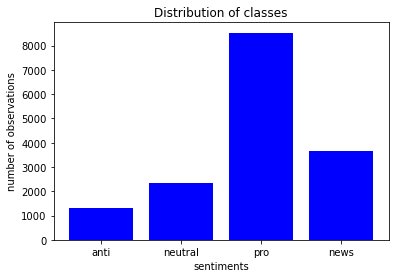

In [187]:
# Get all possible labels
labels = train_data['sentiment'].unique()
heights = [len(pro),len(news),len(neutral),len(anti)]
plt.bar(labels,heights,color='blue')
plt.xticks(labels,['pro','news', 'neutral', 'anti'])
plt.xlabel('sentiments')
plt.ylabel("number of observations")
plt.title('Distribution of classes')
plt.show()

Many of the tweets are from people who believe in man-made climate change. Unresolved class imbalance can lead to the classifier been good at predicting the class(es) with the majority of the data points in the dataset. Whether class imbalance results in poor performance or not is something that will be tested.

The exact percentages of these classes are now inspected using a pie chart.

**Pie Chart**

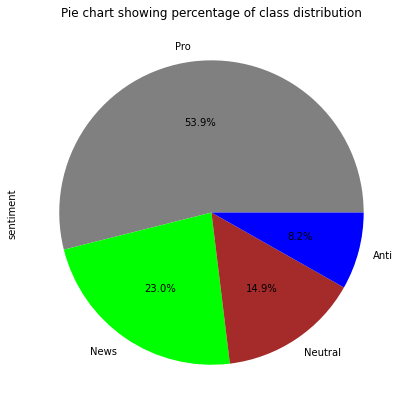

In [188]:
plt.figure(figsize=(7,7))
train_data["sentiment"].value_counts().plot.pie(labels=['Pro', 'News', 'Neutral', 'Anti'], 
                                                autopct='%.1f%%',
                                                title = 'Pie chart showing percentage of class distribution',
                                                colors = ['grey','lime','brown','blue'])

More that 50% of the tweets belong to the pro class. Recall that the pro class represent tweets of people who believe in man-made climate change. This could be an indication that people are finally acknowledging this phenomenon, and more people are becoming aware of it.

**Length of tweets per class**

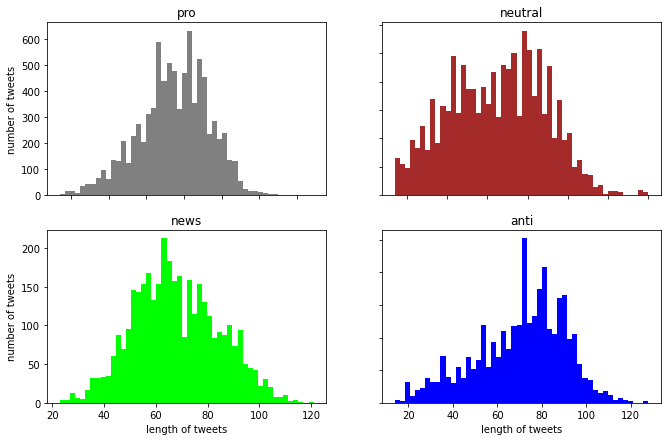

In [189]:
fig, axs = plt.subplots(2, 2, figsize=(11,7))

axs[0, 0].hist(pro.message.str.len(),bins=50,label='pro',color='grey')
axs[0, 0].set_title('pro')

axs[1, 0].set_title('news')
axs[1, 0].hist(news.message.str.len(),bins=50,label='news',color='lime')

axs[0, 1].set_title('neutral')
axs[0, 1].hist(neutral.message.str.len(),bins=50,label='neutral',color='brown')

axs[1, 1].set_title('anti')
axs[1, 1].hist(anti.message.str.len(),bins=50,label='anti',color='blue')

for ax in axs.flat:
    ax.set(xlabel='length of tweets', ylabel='number of tweets')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

It seems like the length for most tweets lie in the 20-120 range in all classes.

The length of tweets for each sentiment class are bell-shaped, and hence have a normal distribution. Since they follow a normal distribution, the mean of the length of tweets can be gauged (which is the highest point on the bell curve).

news tweets have the lowest mean length. This could be explained by the fact that news tweets tend to be concise, and contains just a headline or a link to the full article, hence the length is shorter.

**Wordclouds: Visualizing frequently used words in the tweets**

A word cloud is a technique used in visualization to represent text data in such a way that the size of each word in the text indicate its significance or occurrences. Words that are largely displayed have a high frequency in the text.

**WordCloud 1: Top 50 Words**

In [190]:
all_words = ''.join([label for label in train_data['message']])

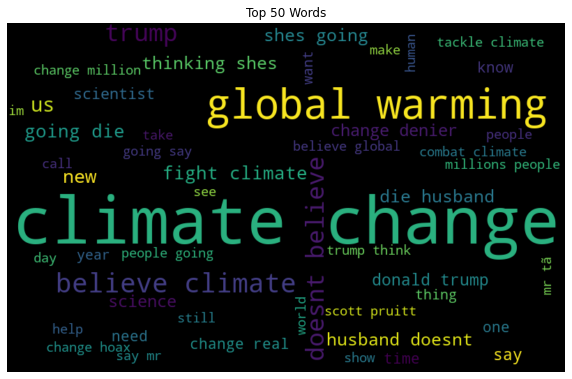

In [191]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words')
plt.show()

This visual depicts the 50 most common words in the dataset.

Words like "climate change", "global warming" and "science" are included.

**WordCloud2: Top 50 Words in "Pro" Tweets**

In [192]:
pro_tweets = train_data[train_data['sentiment'] == 1]
all_words = ''.join([label for label in pro_tweets['message']])

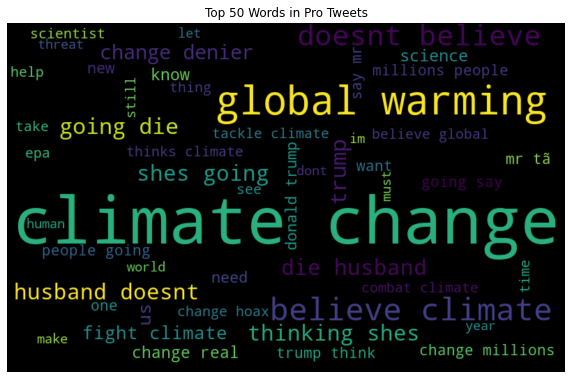

In [193]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words in Pro Tweets')
plt.show()

This visual depicts the 50 most common words among pro tweets.

Words like "change denier", "tackle climate" and "going die" are included.

**WordCloud3: Top 50 Words in "Anti" Tweets**

In [194]:
anti_tweets = train_data[train_data['sentiment'] == -1]
all_words = ''.join([label for label in anti_tweets['message']])

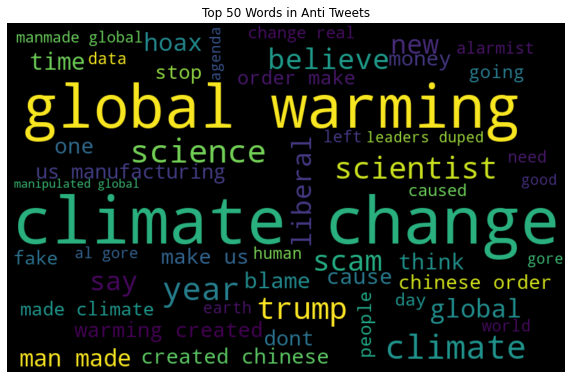

In [195]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words in Anti Tweets')
plt.show()

This visual depicts the 50 most common words among anti tweets.

Words like "chinese", "man made" and "trump" are included.

**WordCloud4: Top 50 Words in "Neutral" Tweets**

In [196]:
neutral_tweets = train_data[train_data['sentiment'] == 0]
all_words = ''.join([label for label in neutral_tweets['message']])

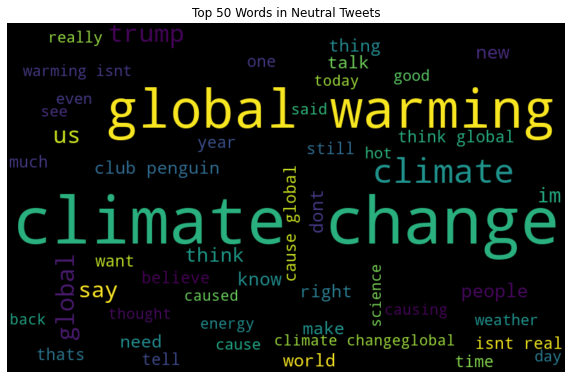

In [197]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words in Neutral Tweets')
plt.show()

This visual depicts the 50 most common words among neutral tweets.

Words like "warming", "global" and "club penguin" are included.

# Feature engineering on text data

https://www.kaggle.com/shivamb/extensive-text-data-feature-engineering on text data simply means extracting features from text using the following techniques:

**Bag of Words**
This extracts features from text and counts the frequency of words in a document (the simplest form).

**TF-IDF**
Tfidf combines **Term Frequency (TF)** and **Inverse Document Frequency (IDF)**. It computes the term frequency-inverse document value for each word. TF is the raw count of a term in a document. IDF is an algorithm that reduces the weight for most common words and add more weight for words that are rare in a document. We compute these two as follows:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)
**Word2Vec**
This is a two layer neutral-net that processes text.

This notebook makes use of the **TF-IDF** method.

Firstly, the data has to be split into labels and features.

**Obtaining X and y**

In [200]:
X = train_data['message']
y = train_data['sentiment'].values

The training data is now split up into the training dataset and the validation dataset.

**Splitting into training and validatioon sets**

In [201]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

**Applying Tfidt**

It counts all the occurrences of the unique words and transforms the tweets to feature vectors
A refinement on top of counting the words is to downscale the weight for words that occur in many tweets (such as "the") and are therefore less informative than those that occur only in a few tweets (such as "climate").
This is achieved by simply dividing the number of occurrences of each word in the tweets by the total number of words in the tweets.

In [202]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf.shape

(12655, 14849)

Note the shape of X_train_tfidf, which indicates the number of features in the feature vector.

# Modelling before resampling

**Models to Fit:**

1. **Logistic Regression**


Logistic Regression models the probability that Y(label) belongs to a certain category (or class). It uses the logistic function to fit the model using the maximum likelihood method. It produces an S-shaped curve. This model can be extended to Multi-class classification, where multiple logistic models can be combined using the one-vs-rest approach.


2. **Support Vector Machine**

In classification, an SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on the side of the gap on which they fall.
. In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.

# **Modelling with default parameters**

Remember that only the training set has been vectorized into a full vocabulary. In order to perform an analysis on the test set, it has to be submitted to the same procedures. Hence, the Pipeline class is used.

In [203]:
def fit_evaluate_model(model, X_train, y_train):
    
    """ 
    Function takes a model to train as input, and returns the performance
    of said model (in the form of various metrics). 
    
    """
    
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf',model)])
    
    # Fit the model to the training set
    text_clf.fit(X_train, y_train) 
    
    # Obtain predictions on the training and validation set
    y_pred = text_clf.predict(X_train)
    y_pred_test=text_clf.predict(X_test)
    
    # Determining the performance of the model
    accuracy = accuracy_score(y_train,y_pred)
    precision = precision_score(y_train,y_pred,average='weighted')
    recall = recall_score(y_train,y_pred,average='weighted')
    f1 = f1_score(y_train,y_pred,average='weighted')
    f1_test = f1_score(y_test,y_pred_test,average='weighted')
    
    # Creating a dictionary for the metrics
    performance = {"accuracy": accuracy,"precision":precision,
                   "recall":recall,"f1_score":f1,"f1_test_score":f1_test}
    
    output = pd.DataFrame([performance])

 
    return output

**Model 1 : Logistic Regression**

In [204]:
model1 = LogisticRegression(max_iter=10000)
logistic_model = fit_evaluate_model(model1, X_train, y_train)

**Model 2 : Linear SVM model**

In [205]:
model2 = LinearSVC()
linear_svc = fit_evaluate_model(model2, X_train, y_train)

**Model 3 : Kernel SVM Model**

In [206]:
model3 = SVC(kernel = 'rbf')
kernel_svc = fit_evaluate_model(model3, X_train, y_train)

**Model 4 : K-NN Model**

In [207]:
model4 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
k_nn = fit_evaluate_model(model4,X_train, y_train)

**Assessing the performance**

In [208]:
assess = pd.concat([logistic_model, linear_svc, kernel_svc, k_nn])
assess.index = ['Logistic Regression','Linear SVM Model','Kernel SVM Model', 'K-NN Model']
assess

,accuracy,precision,recall,f1_score,f1_test_score
Logistic Regression,0.837693,0.850439,0.837693,0.827584,0.701200
Linear SVM Model,0.965152,0.965417,0.965152,0.964994,0.717291
Kernel SVM Model,0.953141,0.955186,0.953141,0.952324,0.697707
K-NN Model,0.747926,0.746535,0.747926,0.746969,0.636590


The imbalance in our data can also be seen in the accuracy being significantly higher than the f1 score across all the models.

The models' performance can now be improved through **hyperparametric tuning.**

# Hyperparameter tuning

A hyperparameter is a value that is set before the model is trained. Different models have different algorithms, and hence have different hyperparameters.

Firstly, the hyperparameters of the fitted models are inspected:

**Logistic Regression**


C: controls regularization (shrinkage). The smaller value of C, the greater the amount of shrinkage that takes place.

**Support Vector Classifier**


C: controls the penalty of the error term.
gamma: kernel coefficient.
(Support Vector Classifier has tons of hyperparameters, but only these two are focused on, for the sake of efficiency).

**KNN**


n_neighbors: number of nearest neighbors.



Hyperparameter Tuning/Optimization is the process of selecting a certain combination of hyperparameters that are optimal for our model.

There are many techniques to tune the hyperparameters; this notebook uses the GridSearch method.

A GridSearch is an optimization process that finds the best hyperparameters. It is a trial-and-error method used to train the model of various combinations of the specified hyperparameters. The hyperparameters chosen are the ones that fully optimize the model.

In [209]:
def tuned_model(model, parameters):
    
    """ 
    Function takes a model to train and parameters to optimize as input,
    and returns the best parameters and best F1-Score of said model.
    
    """
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf',model)]) 
    
    grid_search = GridSearchCV(estimator = text_clf,
                               param_grid = parameters,
                               scoring = 'f1_weighted',
                               cv = 10,
                               n_jobs = -1)
    grid_search = grid_search.fit(X_train, y_train)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    print("Best f1-score: {:.2f}".format(best_accuracy))
    print("Best Parameters:", best_parameters)

**Model 1: Logistic Regression**

In [210]:
parameters = [{'clf__C': [0.05], 'clf__penalty': ['l1'], 'clf__solver': ['liblinear'], 'clf__verbose':[1]},
              {'clf__C': np.linspace(1,10,10)}] 

tuned_model(model1, parameters)

Best f1-score: 0.71
Best Parameters: {'clf__C': 4.0}


**Model 2: Linear SVC**

In [211]:
parameters = [{'clf__C': np.linspace(1,10,10), 'clf__penalty': ['l1','l2']}]

tuned_model(model2, parameters)

Best f1-score: 0.71
Best Parameters: {'clf__C': 1.0, 'clf__penalty': 'l2'}


**Model 3: Kernel SVM**

**The following lines of code took hours to load:**
    

parameters = [{'clf__C': [1, 10, 100], 'clf__kernel': ['poly', 'rbf'],'clf__gamma': ['scale', 'auto']}] 

tuned_model(model3, parameters)


**And the output:**

Best f1-score: 0.73 

Best Parameters: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

**Model 4: K-NN**

In [212]:
parameters = [{'clf__n_neighbors': [5, 6, 7, 8, 9, 10]}]

tuned_model(model4, parameters)

Best f1-score: 0.63
Best Parameters: {'clf__n_neighbors': 6}


**Assessing the performance after hyperparameter tuning**

In [213]:
data = {'F1-Score after tuning': [0.71, 0.70, 0.73, 0.63]}
index=['Logistic Regression Tuned', 'Linear SVC Tuned', 'Kernel SVC Tuned', 'KNN Tuned']
summary = pd.DataFrame(data = data, index=index)
summary

,F1-Score after tuning
Logistic Regression Tuned,0.71
Linear SVC Tuned,0.70
Kernel SVC Tuned,0.73
KNN Tuned,0.63


# Modelling after resampling

**Resampling**

As mentioned before, the classes are imbalanced. The imbalance in the classes are fixed by resampling. Resampling consists of three techniques:


**Upsampling** the minority class - increasing the minority class by resampling from observations to match the number of observations in the majority class.

**Downsampling** the majority class - reducing the number of observations in the majority class to match those of the minority class.

**Synthetic data** - another type of upsampling method where the number of observations in the minority class are inflated, but by generating new observations which are very similar to (but not identical to) existing samples in the minority class.

This notebook uses the upsampling and downsampling methods.

The model performance can possibly be improved by rebalancing our data. Before this is done, the current distribution of the classes are examined:

In [214]:
# Separate the classes
news = train_data[train_data['sentiment']==2]
pro = train_data[train_data['sentiment']==1]
neutral = train_data[train_data['sentiment']==0]
anti = train_data[train_data['sentiment']==-1]

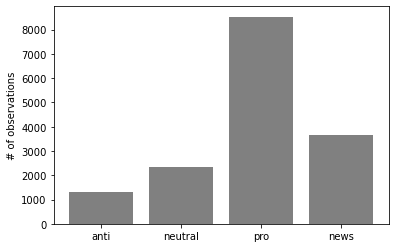

In [215]:
# Get all possible labels
labels = train_data['sentiment'].unique()
heights = [len(pro),len(news),len(neutral),len(anti)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['pro','news', 'neutral', 'anti'])
plt.ylabel("# of observations")
plt.show()

**Downsampling the majority class**

Since the pro class has so many observations, its size can be reduced by taking a small random subset of observations to match the size of the news class.

In [216]:
# Downsample majority
pro_downsampled = resample(pro,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(news)) # match number in minority class

# Combine downsampled majority class with minority classes
downsampled = pd.concat([pro_downsampled, anti, neutral, news])

# Check new class counts
downsampled['sentiment'].value_counts()

 2    3640
 1    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

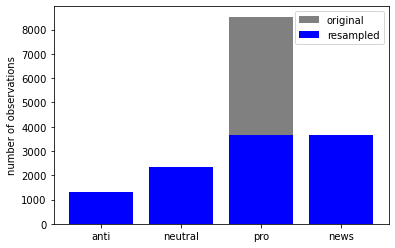

In [217]:
downsampled_heights = [len(downsampled[downsampled['sentiment']==1]),len(downsampled[downsampled['sentiment']==2]),
                       len(downsampled[downsampled['sentiment']==0]),len(downsampled[downsampled['sentiment']==-1])]

# Get all possible labels
labels = train_data['sentiment'].unique()
plt.bar(labels,heights,color='grey')
plt.bar(labels,downsampled_heights,color='blue')
plt.xticks(labels,['pro','news', 'neutral', 'anti'])
plt.ylabel("number of observations")
plt.legend(['original','resampled'])   
plt.show()

**Upsampling the minority class**

Here, random copies of observations in the anti and neutral classes are made until we match the size of the news class. Using this approach means that there will be more data; however the model will be prone to overfitting.



In [218]:
# Upsample minority
anti_upsampled = resample(anti,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(news)) # match number in minority class
                          

# Combine upsampled anti class with majority classes
up_sampled = pd.concat([pro_downsampled, anti_upsampled, neutral, news])


# Check new class counts
up_sampled['sentiment'].value_counts()

-1    3640
 2    3640
 1    3640
 0    2353
Name: sentiment, dtype: int64

In [219]:
# Upsample minority
neutral_upsampled = resample(neutral,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(news)) # match number in minority class

# Combine upsampled neutral class with majority class
final = pd.concat([pro_downsampled, anti_upsampled, neutral_upsampled, news])

# Check new class counts
final['sentiment'].value_counts()

-1    3640
 2    3640
 1    3640
 0    3640
Name: sentiment, dtype: int64

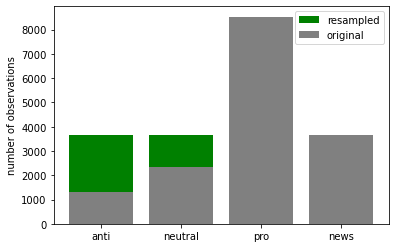

In [220]:
upsampled_heights = [len(final[final['sentiment']==1]),len(final[final['sentiment']==2]),
                     len(final[final['sentiment']==0]),len(final[final['sentiment']==-1])]

# Get all possible labels
labels = train_data['sentiment'].unique()
plt.bar(labels,upsampled_heights,color='green')
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['pro','news', 'neutral', 'anti'])
plt.ylabel("number of observations")
plt.legend(['resampled','original'])
plt.show()

**Visualizing the new data:**

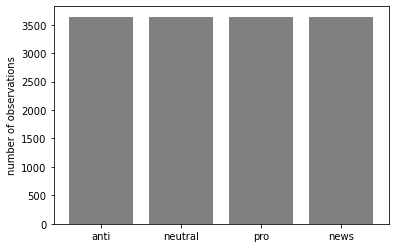

In [221]:
# Get all possible labels
labels = train_data['sentiment'].unique()
heights = [len(final[final['sentiment']==1]),len(final[final['sentiment']==2]),
           len(final[final['sentiment']==0]),len(final[final['sentiment']==-1])]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['pro','news', 'neutral', 'anti'])
plt.ylabel("number of observations")
plt.show()

These are now evenly distributed observations that can now be thrown at any classification model.

The data is now split into labels and features, and the training set is split up into the training and validation datasets.

**Splitting into the training and validation datasets**

In [222]:
X = final['message'] 
y = final['sentiment'].values

X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

**Modelling**

In [223]:
# Logistic Regression
logreg = fit_evaluate_model(model1, X_train_resampled, y_train_resampled) 
# Linear SVC model
l_svc = fit_evaluate_model(model2, X_train_resampled, y_train_resampled)
# Kernel SVM Model
k_svc = fit_evaluate_model(model3, X_train_resampled, y_train_resampled)
# K_Nearest Neighbours
knn = fit_evaluate_model(model4, X_train_resampled, y_train_resampled)

**Assessing the performance on resampled data**

In [224]:
assess_resampled = pd.concat([logreg,l_svc,k_svc, knn])
assess_resampled.index = ['Logistic Regression Resampled','Linear SVM Model Resampled',
                          'Kernel SVM Model Resampled', 'K-NN Model Resampled']
assess_resampled

,accuracy,precision,recall,f1_score,f1_test_score
Logistic Regression Resampled,0.915522,0.915668,0.915522,0.915149,0.772947
Linear SVM Model Resampled,0.981885,0.981895,0.981885,0.981872,0.801005
Kernel SVM Model Resampled,0.988238,0.988290,0.988238,0.988240,0.830714
K-NN Model Resampled,0.763049,0.769617,0.763049,0.756196,0.616711


An improvement of the models on the validation set can be seen since the data has been resampled.

# Submissions to Kaggle

Submissions are now made to Kaggle to see the performance of the models on the true testing dataset. These F1-scores are the ones that carry the most weight.

In [225]:
def testing(model, filename, X, y):
    
    """" 
    Function takes a model, and X and y variables to train as input,
    and returns a csv file of predictions (named as "filename") to 
    submit to Kaggle in order to obtain the true F1-score. 
    
    """
    test_x = test_data['message']
    
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                         ('clf',model)])
    
    # Fit the model to the training set
    text_clf.fit(X, y) 
    
    # Obtain predictions on the testing set
    y_pred = text_clf.predict(test_x)
    
    # Save predictions in a new DataFrame
    predictions = pd.DataFrame(y_pred, columns=['sentiment'], index = test_data.index)
    predictions.reset_index(inplace=True)
    
    return predictions.to_csv(filename+'.csv', index=False)

In [226]:
# return predictions.to_csv('/kaggle/working/'+filename+'.csv', index=False)

All the models built in this notebook are now evaluated according to the performance metric (The F1-Score) on the testing set:

**Models with default parameters**

**Logistic Regression: F1 Score = 0.73364**

In [227]:
testing(model1, 'LogReg', X_train, y_train)

**Linear SVC: F1 Score = 0.74834**

In [228]:
testing(model2, 'LinearSVC', X_train, y_train)

**Kernel SVM: F1 Score = 0.73577**

In [229]:
testing(model3, 'KernelSVC', X_train, y_train)

**K-NN: F1 Score = 0.64971**

In [230]:
testing(model4, 'KNN', X_train, y_train)

# Models with tuned hyperparameters

**Logistic Regression: F1 Score = 0.75225**

In [231]:
testing(LogisticRegression(C=6.0, max_iter=10000), 'LogReg_Tuned', X_train, y_train)

**Kernel SVM: F1 Score = 0.75651**

In [232]:
testing(KNeighborsClassifier(leaf_size=20, n_neighbors=9), 'KNN_Tuned', X_train, y_train)

# Models with resampled data

**Logistic Regression: F1 Score = 0.65483**

In [233]:
testing(model1, 'LogReg_Resampled', X_train_resampled, y_train_resampled)

**Linear SVC: F1 Score = 0.65659**

In [234]:
testing(model2, 'LinearSVC_Resampled', X_train_resampled, y_train_resampled)

**Kernel SVM: F1 Score = 0.69689**

In [235]:
testing(model4, 'KNN_Resampled', X_train_resampled, y_train_resampled)

**Evaluating the models**

Now we evaluate the performance of all the models:

In [236]:
arrays = [['Before Resampling', 'Before Resampling', 'Before Resampling', 'Before Resampling', 
           'Before Resampling Tuned', 'Before Resampling Tuned', 'Before Resampling Tuned',
           'Before Resampling Tuned', 'After Resampling', 'After Resampling', 'After Resampling',
           'After Resampling'],
          ['Logistic Regression', 'Linear SVC', 'Kernel SVC', 'K-Nearest Neighbours',
           'Logistic Regression', 'Linear SVC', 'Kernel SVC', 'K-Nearest Neighbours',
           'Logistic Regression', 'Linear SVC', 'Kernel SVC', 'K-Nearest Neighbours']]

tuples = list(zip(*arrays))

In [237]:
index = pd.MultiIndex.from_tuples(tuples, names=[' ', 'Model'])

data = {'Train F1-Score': [0.8289, 0.9628, 0.9534, 0.7479, '--', '--', '--', '--',
                           0.9083, 0.9797, 0.9879, 0.7531],
        'Validation F1-Score': [0.7114, 0.7172, 0.7068, 0.6416, 0.7100,0.7000, 0.7300,
                                0.6300, 0.7781, 0.8029, 0.8346, 0.6350],
        'Test F1-Score': [0.7336, 0.7483, 0.7358, 0.6497, 0.7526, 0.7483, 0.7565, 0.6526,
                         0.6548, 0.6566, 0.6969, 0.4988]}

summary = pd.DataFrame(data = data, index = index)

In [238]:
summary

Train F1-Score  \
                        Model                                 
Before Resampling       Logistic Regression          0.8289   
                        Linear SVC                   0.9628   
                        Kernel SVC                   0.9534   
                        K-Nearest Neighbours         0.7479   
Before Resampling Tuned Logistic Regression              --   
                        Linear SVC                       --   
                        Kernel SVC                       --   
                        K-Nearest Neighbours             --   
After Resampling        Logistic Regression          0.9083   
                        Linear SVC                   0.9797   
                        Kernel SVC                   0.9879   
                        K-Nearest Neighbours         0.7531   

                                              Validation F1-Score  \
                        Model                                       
Before Resampling       Logistic Regression                0.7114   
                        Linear SVC                         0.7172   
                        Kernel SVC                         0.7068   
                        K-Nearest Neighbours               0.6416   
Before Resampling Tuned Logistic Regression                0.7100   
                        Linear SVC                         0.7000   
                        Kernel SVC                         0.7300   
                        K-Nearest Neighbours               0.6300   
After Resampling        Logistic Regression                0.7781   
                        Linear SVC                         0.8029   
                        Kernel SVC                         0.8346   
                        K-Nearest Neighbours               0.6350   

                                              Test F1-Score  
                        Model                                
Before Resampling       Logistic Regression          0.7336  
                        Linear SVC                   0.7483  
                        Kernel SVC                   0.7358  
                        K-Nearest Neighbours         0.6497  
Before Resampling Tuned Logistic Regression          0.7526  
                        Linear SVC                   0.7483  
                        Kernel SVC                   0.7565  
                        K-Nearest Neighbours         0.6526  
After Resampling        Logistic Regression          0.6548  
                        Linear SVC                   0.6566  
                        Kernel SVC                   0.6969  
                        K-Nearest Neighbours         0.4988

# Saving the best model

In [239]:
def the_fit(model):
    
    text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', model)])

    # Feed the training data through the pipeline
    return text_clf.fit(X_train, y_train) 
    

In [240]:
# The best model
best_model = SVC(kernel='rbf', C=100, gamma='scale')
kernel_svc = the_fit(best_model)

In [241]:
model = kernel_svc 
model_save_path = "model_1.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model,file)

# Logging to comet

In [242]:
# Log best model parameters
best_model_hyperparams = {'clf__C': 100, 'clf__gamma': 'scale',
                     'clf__kernel': 'rbf'}
# Log best model F1 score

In [243]:
# Log best model

# Conclusion

The purpose of this notebook was to build a classifier to determine whether a person believes if climate change is man-made or not, based on their novel tweet data.

Various text preprocessing methods (such as noise removal and object standardisation) were applied to the tweets, so that they could be thrown at any classification model.

Exploratory data analysis was done, such as visualising the length of tweets per sentiment class, and the most common words found in each sentiment class.

It was found that the data was heavily imbalanced; modelling was done before resampling the data and compared to the modelling done after resampling the data. Modelling done after resampling exhibited the tendency of the models to overfit the resampled data.

Hyperparametric tuning was also applied in order to optimize the models.

From the various models built, the best model is chosen according to the performance metric. In this case, the best model is the one which exhibits the highest F1-Score.

Hence, the classifier chosen to predict the sentiment of tweets related to climate change is the fully optimized Kernel SVM model (before resampling).